In [44]:
import os
import re
import numpy as np
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d
from numpy.polynomial.chebyshev import Chebyshev
from tqdm import tqdm  # For progress bars
from collections import defaultdict
import corner
import seaborn as sns
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# # Define the path to the allStar catalog
# allstar_file = 'lab2_data/allStar-dr17-synspec_rev1.fits'

# # Open the FITS file and read the data
# with fits.open(allstar_file) as hdulist:
#     data = Table(hdulist[1].data)

In [3]:
# # List of fields of interest
# fields = ['M15', 'N6791', 'K2_C4_168-21', '060+00']

# # Filter data based on the 'FIELD' column
# data_filtered = data[np.isin(data['FIELD'], fields)]

# # Create a mask for entries with all required labels present
# labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
# mask = np.ones(len(data_filtered), dtype=bool)
# for label in labels:
#     mask &= ~np.isnan(data_filtered[label])

# data_filtered = data_filtered[mask]

# # Apply SNR >= 50 cut
# data_filtered = data_filtered[data_filtered['SNR'] >= 50]

# # Exclude stars with LOGG > 4 or TEFF > 5700 K
# data_filtered = data_filtered[(data_filtered['LOGG'] <= 4) & (data_filtered['TEFF'] <= 5700)]

# # Exclude stars with FE_H < -1
# data_filtered = data_filtered[data_filtered['FE_H'] >= -1]

# print(f"Total number of stars: {len(data_filtered)}")

# # Save the filtered Astropy Table to a FITS file
# data_filtered.write('lab2_data/filtered_training_set.fits', overwrite=True)

# print("Filtered Astropy Table saved to 'lab2_data/filtered_training_set.fits'")

In [4]:
# # Define the base URLs
# aspcap_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1"
# apstar_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars"

# # Extract the relevant columns from the filtered data
# apogee_ids = data_filtered['APOGEE_ID']
# telescopes = data_filtered['TELESCOPE']
# fields = data_filtered['FIELD']

# # Define the folder to save the spectra
# output_folder = "lab2_data/apStar_spectra"
# os.makedirs(output_folder, exist_ok=True)

# # Function to download a file from a given URL
# def download_spectra(url, filename):
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open(filename, 'wb') as file:
#             file.write(response.content)
#         print(f"Downloaded: {filename}")
#     else:
#         print(f"Failed to download: {url}")

# # Loop over the filtered data and construct the URLs
# for apogee_id, telescope, field in zip(apogee_ids, telescopes, fields):
#     # Construct the apStar file URL
#     apstar_url = f"{apstar_base_url}/{telescope}/{field}/apStar-dr17-{apogee_id}.fits"
#     apstar_filename = os.path.join(output_folder, f"apStar-dr17-{apogee_id}.fits")
    
#     # Download the apStar file
#     download_spectra(apstar_url, apstar_filename)

In [5]:
def load_filtered_training_set(filepath='lab2_data/filtered_training_set.fits'):
    data_filtered = Table.read(filepath)
    return data_filtered


In [6]:
def plot_apstar_spectrum(apstar_filename, downsample_factor=1):
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract coadded flux (multi-visit spectrum)
        flux = hdulist[1].data  # Coadded flux data is in the second HDU
        header = hdulist[1].header  # Header contains necessary metadata
        
        # Debug: Check the shape of flux
        print("Flux shape before processing:", flux.shape)
        
        # Handle multi-dimensional flux data
        if flux.ndim > 1:
            # Option 2: Select a specific spectrum
            flux = flux[0]  
            print("Flux shape after flattening:", flux.shape)
        
        # Reconstruct the wavelength array
        crval = header['CRVAL1']  # Starting wavelength
        cdelt = header['CDELT1']  # Wavelength step (Δλ)
        num_pixels = len(flux)     # Number of flux points (pixels)
        wavelength = crval + cdelt * np.arange(num_pixels)

        # Downsample the data by averaging over groups of points
        downsampled_wavelength = wavelength[::downsample_factor]
        downsampled_flux = flux[::downsample_factor]

        # Plot downsampled flux vs wavelength
        plt.figure(figsize=(12, 6))
        plt.plot(downsampled_wavelength, downsampled_flux, label='Downsampled Spectrum', 
                 color='#1f77b4', linewidth=0.8, alpha=0.9)
        
        # Enhance the plot
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Flux (Arbitrary Units)', fontsize=12)
        plt.title(f'Spectrum (Downsampled): {os.path.basename(apstar_filename)}', fontsize=14)
        plt.legend(fontsize=10)
        
        # Add grid for better readability
        plt.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()


In [7]:
def extract_unique_id(filename):
    # Updated regex: case-insensitive, captures unique ID with or without '.fits'
    match = re.search(r'(2M\d+[+-]\d+)', filename, re.IGNORECASE)
    if match:
        unique_id = match.group(1).upper()
        return unique_id
    else:
        logging.warning(f"Failed to extract Unique ID from filename: {filename}")
        return None


In [8]:
def process_spectrum_with_bitmask(apstar_filename, large_error_value=1e10, plot=False, plot_bad_pixels=True):
    with fits.open(apstar_filename) as hdulist:
        flux = hdulist[1].data
        error = hdulist[2].data
        bitmask = hdulist[3].data
        header = hdulist[1].header

        if flux.ndim > 1:
            flux = flux[0]
            error = error[0]
            bitmask = bitmask[0]

        crval = header['CRVAL1']  # Starting log10(wavelength)
        cdelt = header['CDELT1']  # Delta log10(wavelength)
        num_pixels = len(flux)
        logwavelength = crval + cdelt * np.arange(num_pixels)
        wavelength = 10 ** logwavelength  # Convert to linear Å

        max_wavelength = 16950
        valid_mask = wavelength <= max_wavelength
        wavelength = wavelength[valid_mask]
        flux = flux[valid_mask]
        error = error[valid_mask]
        bitmask = bitmask[valid_mask]

        bad_bits_mask = (
            (bitmask & (1 << 0)) |   # BADPIX
            (bitmask & (1 << 1)) |   # CRPIX
            (bitmask & (1 << 2)) |   # SATPIX
            (bitmask & (1 << 3)) |   # UNFIXABLE
            (bitmask & (1 << 4)) |   # BADDARK
            (bitmask & (1 << 5)) |   # BADFLAT
            (bitmask & (1 << 6)) |   # BADERR
            (bitmask & (1 << 7)) |   # NOSKY
            (bitmask & (1 << 12))    # SIG_SKYLINE
        )
        bad_pixel_mask = bad_bits_mask > 0
        error[bad_pixel_mask] = large_error_value

        if plot:
            # Plot the spectrum (flux) first
            plt.figure(figsize=(12, 6))
            
            plt.plot(wavelength, flux, label='Spectrum', color='#1f77b4', linewidth=0.5, zorder=1)
            if plot_bad_pixels:
                plt.scatter(wavelength[bad_pixel_mask], flux[bad_pixel_mask], color='#d62728', s=2, label='Bad Pixels', zorder=2, alpha=0.8)
                plt.title(f'Spectrum with Bad Pixels Marked: {os.path.basename(apstar_filename)}', fontsize=14)
            else:
                plt.title(f'Spectrum: {os.path.basename(apstar_filename)}', fontsize=14)
            
            # Set labels and title
            plt.xlabel('Wavelength (Å)', fontsize=12)
            plt.ylabel('Flux (Arbitrary Units)', fontsize=12)
            
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3, linestyle='--')
        
            
            plt.tight_layout()
            plt.show()

        return flux, error, wavelength, bad_pixel_mask, apstar_filename


In [9]:
def load_continuum_pixels(filename):
    continuum_data = np.load(filename)
    continuum_wavelengths = continuum_data['wavelengths'][continuum_data['trusted']]
    return continuum_wavelengths


In [10]:
def find_closest_indices(spectrum_wavelengths, target_wavelengths):
    if len(spectrum_wavelengths) == 0 or len(target_wavelengths) == 0:
        print("find_closest_indices: One of the input arrays is empty.")
        return np.array([])  # Return empty array if either input is empty

    indices = np.searchsorted(spectrum_wavelengths, target_wavelengths)
    indices = np.clip(indices, 1, len(spectrum_wavelengths) - 1)
    left = spectrum_wavelengths[indices - 1]
    right = spectrum_wavelengths[indices]
    comparison = np.abs(target_wavelengths - left) < np.abs(target_wavelengths - right)
    indices -= comparison.astype(int)
    return indices


In [11]:
def normalize_spectrum(flux, wavelength, bad_pixel_mask, continuum_wavelengths, plot=False):
    # Exclude bad pixels
    flux = flux[~bad_pixel_mask]
    wavelength = wavelength[~bad_pixel_mask]

    # Define wavelength ranges for each chip
    chip_wavelength_ranges = [
        (15140, 15810),  # Chip 1
        (15860, 16430),  # Chip 2
        (16470, 16950)   # Chip 3
    ]

    # Initialize continuum
    continuum = np.zeros_like(flux)

    # Process each chip
    for chip_min_wave, chip_max_wave in chip_wavelength_ranges:
        chip_mask = (wavelength >= chip_min_wave) & (wavelength <= chip_max_wave)
        chip_wavelength = wavelength[chip_mask]
        chip_flux = flux[chip_mask]

        # Continuum points in this chip
        chip_cont_mask = (continuum_wavelengths >= chip_min_wave) & (continuum_wavelengths <= chip_max_wave)
        chip_cont_wavelength = continuum_wavelengths[chip_cont_mask]

        if len(chip_wavelength) == 0:
            continue  # Skip if no pixels in chip

        if len(chip_cont_wavelength) == 0:
            # No continuum points in this chip, use running median
            continuum_chip = running_median(chip_flux, window_size=50)
        else:
            # Find closest indices
            continuum_indices = find_closest_indices(chip_wavelength, chip_cont_wavelength)

            if len(continuum_indices) == 0:
                continuum_chip = running_median(chip_flux, window_size=50)
            else:
                continuum_flux = chip_flux[continuum_indices]

                # Fit Chebyshev polynomial
                try:
                    cheb_fit = Chebyshev.fit(chip_cont_wavelength, continuum_flux, deg=2)
                    continuum_chip = cheb_fit(chip_wavelength)
                except Exception as e:
                    continuum_chip = running_median(chip_flux, window_size=50)

        continuum[chip_mask] = continuum_chip

    # Handle zero continuum
    zero_continuum_mask = (continuum == 0)
    continuum[zero_continuum_mask] = np.nan

    # Normalize
    normalized_flux = flux / continuum

    # Check if normalized_flux has valid values
    if np.all(np.isnan(normalized_flux)):
        print("Warning: All normalized flux values are NaN.")

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(wavelength, flux, label='Un-normalized Spectrum', color='#1f77b4', alpha=0.8, linewidth=0.5)
        plt.plot(wavelength, continuum, label='Estimated Continuum', color='#d62728', alpha=1, linewidth=1.5)
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Flux', fontsize=12)
        plt.title('Un-normalized Spectrum with Estimated Continuum', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Plot Normalized Flux
        plt.figure(figsize=(12, 6))
        plt.plot(wavelength, normalized_flux, label='Normalized Spectrum', color='#2ca02c', alpha=0.8, linewidth=0.5)
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Normalized Flux', fontsize=12)
        plt.title('Normalized Spectrum Across All Chips', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()

    return normalized_flux, wavelength


In [12]:
def split_spectra_for_training(labels, flux, test_size=0.2, random_state=42):
    train_labels, cv_labels, train_flux, cv_flux = train_test_split(
        labels, flux, test_size=test_size, random_state=random_state
    )
    return (train_labels, train_flux), (cv_labels, cv_flux)


In [13]:
# Step 1: Load the filtered training set
data_filtered = Table.read('lab2_data/filtered_training_set.fits')

# Step 2: Extract label data
labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']

# Initialize a list to hold label data
label_data_list = []

for label in labels:
    column = data_filtered[label]
    if hasattr(column, 'filled'):
        # Column is masked; fill masked values with np.nan
        label_values = column.filled(np.nan)
    else:
        # Column is not masked; extract data directly
        label_values = column.data
    label_data_list.append(label_values)

# Stack the label data into a 2D NumPy array
label_data = np.vstack(label_data_list).T

print(f"Label data shape: {label_data.shape}")  # Expected: (1886, 5)


Label data shape: (1886, 5)


In [14]:
# Step 3: Remove entries with missing label data
valid_label_mask = ~np.isnan(label_data).any(axis=1)
data_filtered_matched = data_filtered[valid_label_mask]
label_data_matched = label_data[valid_label_mask]

print(f"Label data shape after cleaning: {label_data_matched.shape}")  # Expected: (1886, 5) 


Label data shape after cleaning: (1886, 5)


In [15]:
# Step 4: Define paths to spectra
output_folder = "lab2_data/apStar_spectra"
downloaded_files = os.listdir(output_folder)
spectra_files = [os.path.join(output_folder, f) for f in downloaded_files if f.endswith('.fits')]

print(f"Number of spectra files: {len(spectra_files)}")       # Expected: 713
print(f"Number of label entries: {len(data_filtered_matched)}")      # Expected: 713


Number of spectra files: 713
Number of label entries: 1886


In [16]:
# Step 5: Handle multiple observations per spectrum
# Step 5.1: Extract unique IDs and create mapping
spectra_dict = {}
for f in downloaded_files:
    if f.endswith('.fits'):
        unique_id = extract_unique_id(f)
        if unique_id:
            spectra_dict[unique_id] = os.path.join(output_folder, f)

print(f"Number of spectra with valid unique IDs: {len(spectra_dict)}")  # Expected: 713


Number of spectra with valid unique IDs: 713


In [17]:
unique_id_column = 'APOGEE_ID' 

# Ensure that the unique_id_column exists
if unique_id_column not in data_filtered_matched.colnames:
    raise KeyError(f"Column '{unique_id_column}' not found in the labels table.")

# Extract unique IDs from labels
label_unique_ids = data_filtered_matched[unique_id_column].astype(str)

# Identify which label entries have corresponding spectral files
has_spectra_mask = np.isin(label_unique_ids, list(spectra_dict.keys()))

# Filter the labels and labels data to only those with available spectra
data_filtered_final = data_filtered_matched[has_spectra_mask]
label_data_final = label_data_matched[has_spectra_mask]

# Update spectra_files to only include matched files
spectra_files_final = [spectra_dict[uid] for uid in label_unique_ids[has_spectra_mask]]

print(f"Number of matched spectra files: {len(spectra_files_final)}")
print(f"Number of matched label entries: {len(data_filtered_final)}")


Number of matched spectra files: 713
Number of matched label entries: 713


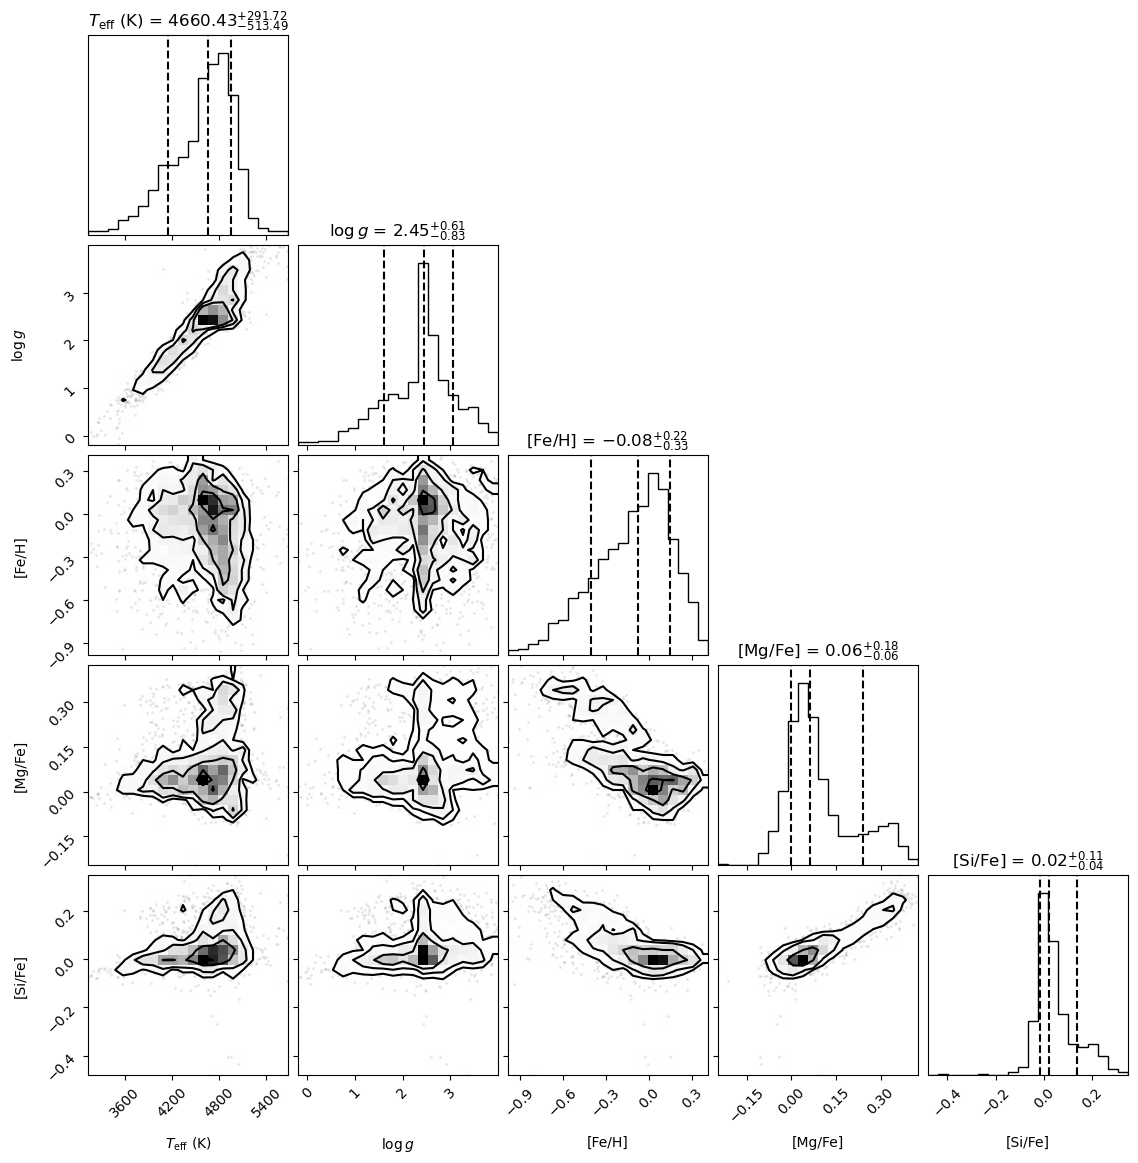

In [18]:
# Extract the labels for plotting
labels_to_plot = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
label_data = np.vstack([data_filtered[label] for label in labels_to_plot]).T

# Define labels for the plot
plot_labels = [r'$T_{\mathrm{eff}}$ (K)', r'$\log g$', r'[Fe/H]', r'[Mg/Fe]', r'[Si/Fe]']

# Create the corner plot
figure = corner.corner(
    label_data,
    labels=plot_labels,
    show_titles=True,
    title_fmt='.2f',
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12}
)
plt.show()

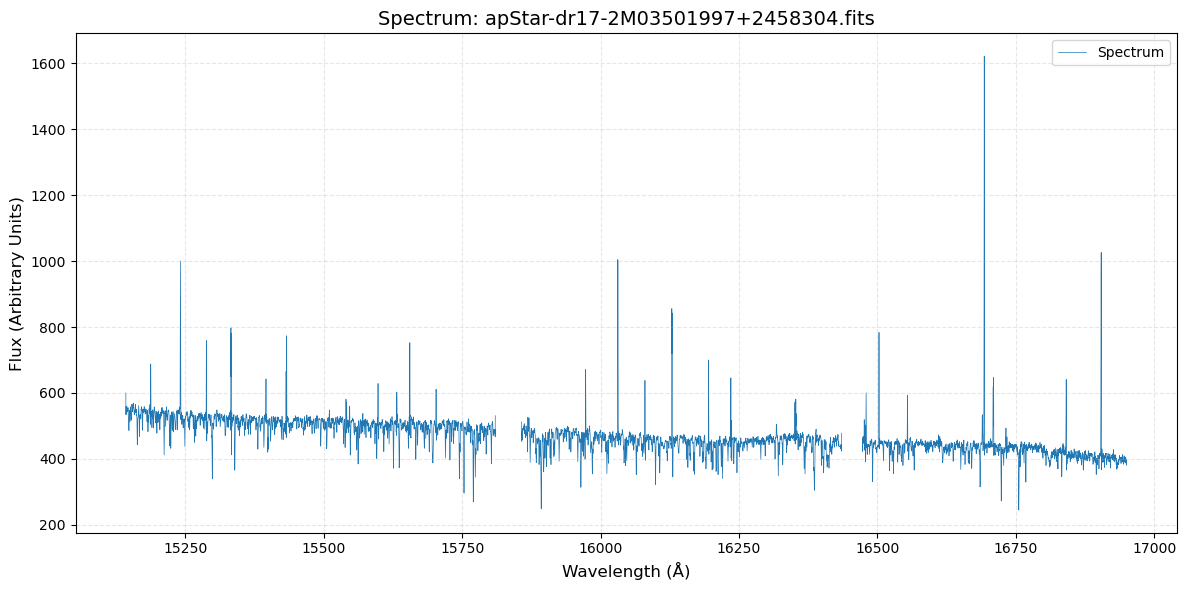

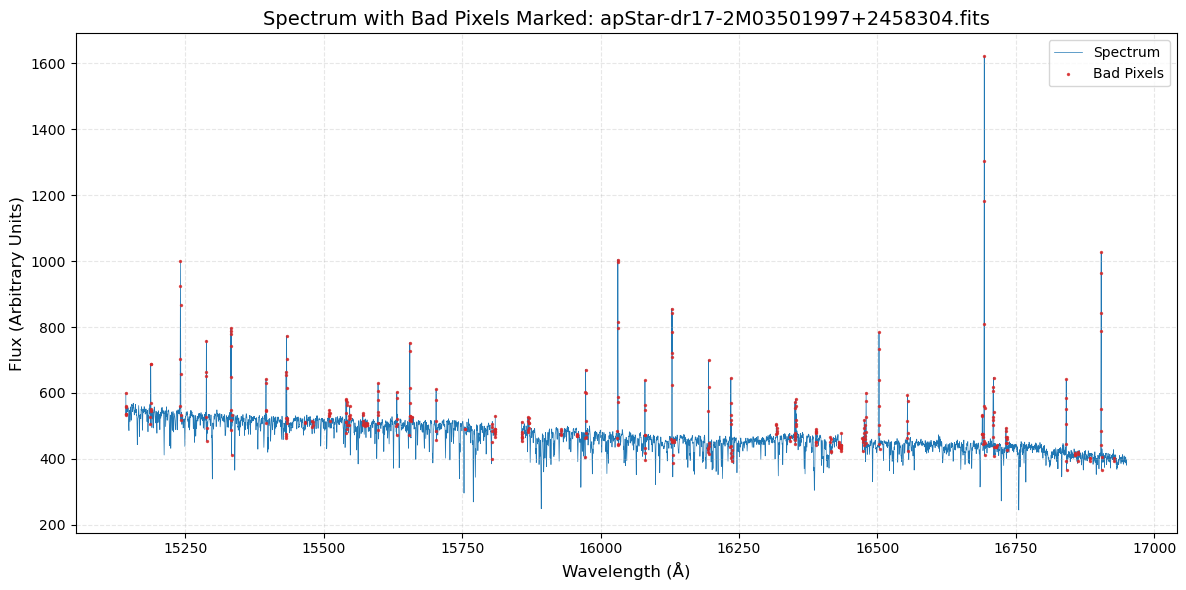

In [19]:
first_apstar_file = spectra_files_final[0]
filename = os.path.basename(first_apstar_file)
unique_id = extract_unique_id(filename)
continuum_pixels_file_path = 'lab2_data/cannon_continuum_apogee.npz'
continuum_wavelengths = load_continuum_pixels(continuum_pixels_file_path)
# Process the spectrum
flux, error, wavelength, bad_pixel_mask, _ = process_spectrum_with_bitmask(first_apstar_file, 
                                                                           large_error_value=1e10, 
                                                                           plot=True, 
                                                                           plot_bad_pixels = False)

flux, error, wavelength, bad_pixel_mask, _ = process_spectrum_with_bitmask(first_apstar_file, 
                                                                           large_error_value=1e10, 
                                                                           plot=True)

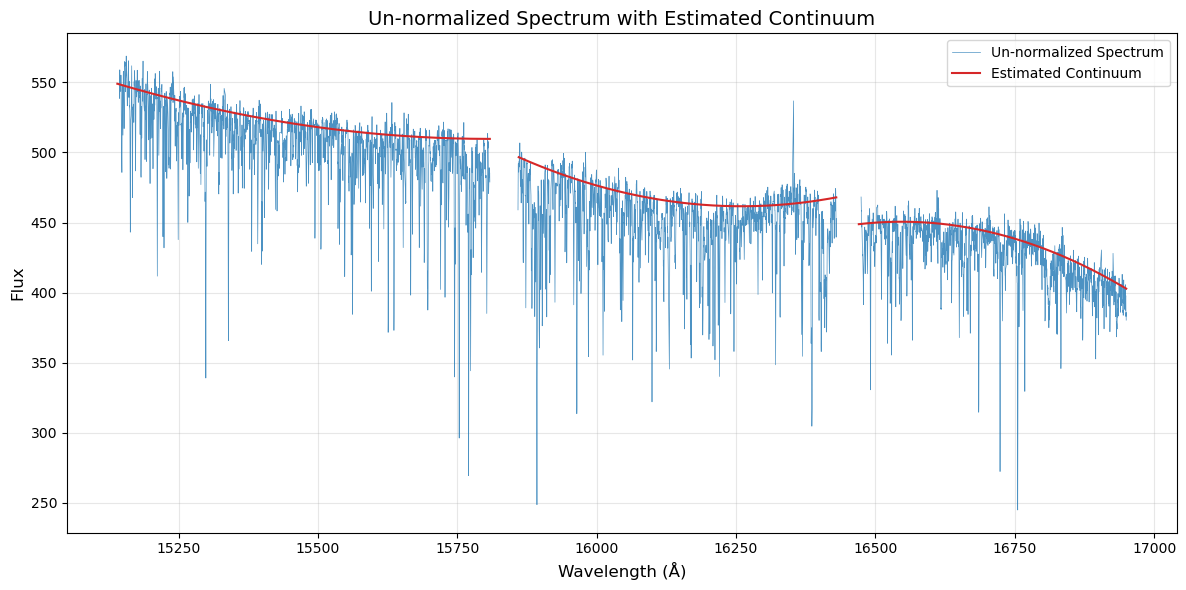

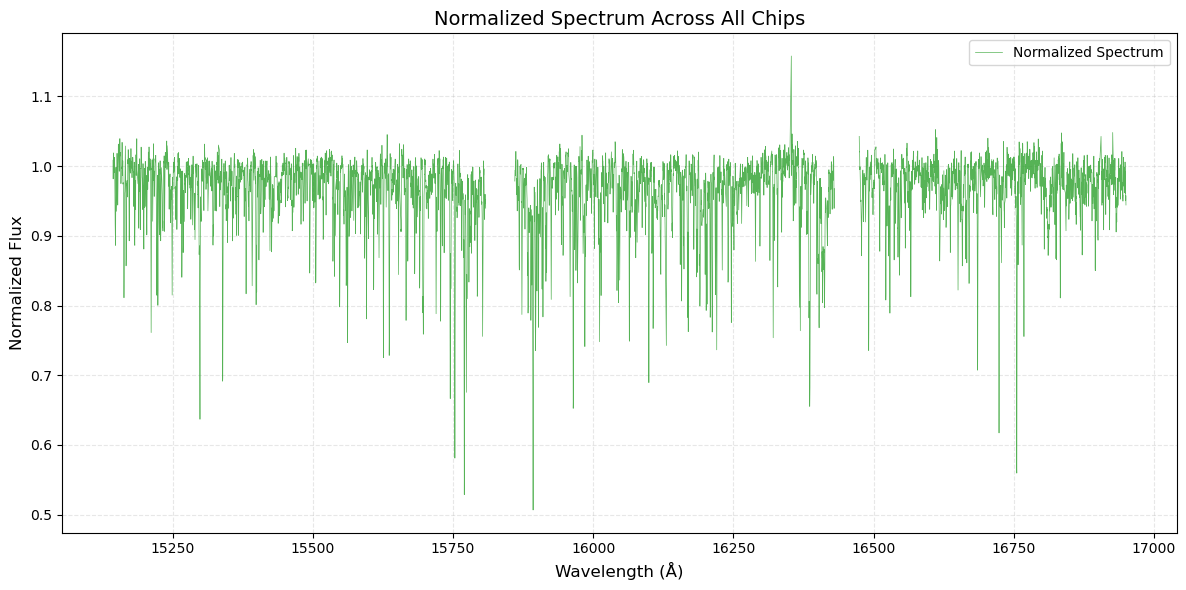

In [20]:
if len(wavelength) == 0:
    logging.warning("Spectrum has no valid pixels after processing.")
else:
    normalized_flux, wavelength = normalize_spectrum(
        flux, wavelength, bad_pixel_mask,
        continuum_wavelengths,
        plot=True  # Set to True to visualize
    )

In [21]:
def process_spectra_list(spectra_files, continuum_wavelengths, plot=False):
    """
    Process a list of spectral FITS files: mask bad pixels and normalize.

    Parameters:
    - spectra_files (list): List of paths to spectral FITS files.
    - continuum_wavelengths (ndarray): Array of continuum wavelengths for normalization.
    - plot (bool): Whether to plot each spectrum.

    Returns:
    - normalized_flux_list (list): List of normalized flux arrays.
    - error_list (list): List of error arrays.
    - wavelength_list (list): List of wavelength arrays corresponding to each spectrum.
    """
    normalized_flux_list = []
    error_list = []
    wavelength_list = []

    for file in tqdm(spectra_files, desc="Processing Spectra"):
        # Process the spectrum: mask bad pixels
        flux, error, wavelength, bad_pixel_mask, _ = process_spectrum_with_bitmask(
            file, 
            large_error_value=1e10, 
            plot=False, 
            plot_bad_pixels=False
        )

        if len(wavelength) == 0:
            logging.warning(f"Spectrum {file} has no valid pixels after processing. Skipping.")
            continue

        # Normalize the spectrum
        normalized_flux, norm_wavelength = normalize_spectrum(
            flux, 
            wavelength, 
            bad_pixel_mask, 
            continuum_wavelengths, 
            plot=False  # Set to True if you want to visualize each normalization
        )

        normalized_flux_list.append(normalized_flux)
        error_list.append(error)
        wavelength_list.append(norm_wavelength)

    return normalized_flux_list, error_list, wavelength_list


In [22]:
def compute_log_likelihood(y, y_pred, V):
    """
    Compute the log-likelihood of the data given the model.
    
    Parameters:
    - y (ndarray): Observed normalized flux values. Shape: (N,)
    - y_pred (ndarray): Predicted flux values from the model. Shape: (N,)
    - V (ndarray): Total variance (s^2_lambda + sigma^2). Shape: (N,)
    
    Returns:
    - log_likelihood (float): The computed log-likelihood value.
    """
    residuals = y - y_pred
    ll = -0.5 * np.sum((residuals ** 2) / V + np.log(2 * np.pi * V))
    return ll

In [23]:
def weighted_least_squares(X, y, W):
    """
    Perform weighted least squares fitting with improved numerical stability.
    """
    # Add small regularization term to diagonal for stability
    epsilon = 1e-8
    
    # Compute weighted design matrix
    XW = X * np.sqrt(W)[:, np.newaxis]  # Using sqrt(W) for better conditioning
    
    # Compute (X^T W X)
    XtWX = XW.T @ XW  # Shape: (P, P)
    
    # Add regularization to diagonal
    XtWX += np.eye(XtWX.shape[0]) * epsilon
    
    # Compute (X^T W y)
    XtWy = XW.T @ (y * np.sqrt(W))  # Shape: (P,)
    
    # Solve using SVD for better stability
    try:
        theta = np.linalg.solve(XtWX, XtWy)
        if np.any(np.isnan(theta)):
            raise np.linalg.LinAlgError
    except np.linalg.LinAlgError:
        # Use pseudo-inverse if direct solve fails
        theta = np.linalg.pinv(XtWX) @ XtWy
    
    return theta

In [24]:
def create_design_matrix(labels, degree=2):
    """
    Create a design matrix with polynomial features up to the specified degree.
    Ensures consistent feature generation and proper scaling.
    """
    # Scale the labels to prevent numerical issues
    scaler = StandardScaler()
    scaled_labels = scaler.fit_transform(labels)
    
    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X = poly.fit_transform(scaled_labels)
    
    # Store the scaler and feature names
    feature_names = poly.get_feature_names_out()
    
    return X, feature_names, scaler, poly

In [25]:
def fit_pixel(y, sigma, X, s2_grid):
    """
    Fit the model for a single wavelength pixel with improved stability.
    """
    log_likelihoods = []
    theta_grid = []
    
    # Remove any NaN values
    valid_mask = ~np.isnan(y) & ~np.isnan(sigma)
    y = y[valid_mask]
    sigma = sigma[valid_mask]
    X = X[valid_mask]
    
    if len(y) < X.shape[1]:
        return np.full(X.shape[1], np.nan), np.nan
    
    for s2 in s2_grid:
        V = s2 + sigma ** 2  # Total variance
        W = 1.0 / V  # Weights
        
        # Skip if all weights are invalid
        if not np.any(np.isfinite(W)):
            continue
            
        theta = weighted_least_squares(X, y, W)
        theta_grid.append(theta)
        
        y_pred = X @ theta
        ll = compute_log_likelihood(y, y_pred, V)
        log_likelihoods.append(ll)
    
    if not log_likelihoods:
        return np.full(X.shape[1], np.nan), np.nan
    
    log_likelihoods = np.array(log_likelihoods)
    theta_grid = np.array(theta_grid)
    
    # Find best parameters
    max_idx = np.argmax(log_likelihoods)
    theta_best = theta_grid[max_idx]
    s2_best = s2_grid[max_idx]
    
    return theta_best, s2_best

In [26]:
# Prediction function with validation
def predict_normalized_spectrum(labels, theta_lambda, scaler, degree=2):
    """
    Predict the normalized spectrum with input validation.
    """
    # Scale the labels using the same scaler used in training
    scaled_labels = scaler.transform(labels.reshape(1, -1))
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X = poly.fit_transform(scaled_labels)
    
    # Predict the normalized flux
    predicted_flux = X @ theta_lambda.T
    
    return predicted_flux.flatten()

In [27]:
test_size = 0.5
random_state = 42  # Seed for reproducibility

# Perform the split
train_flux_files, cv_flux_files, train_labels, cv_labels = train_test_split(
    spectra_files_final,
    label_data_final,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

# Verify the shapes of the split datasets
print(f"Total spectra: {len(spectra_files_final)}")
print(f"Training set: {len(train_flux_files)} spectra")
print(f"Cross-validation set: {len(cv_flux_files)} spectra")

Total spectra: 713
Training set: 356 spectra
Cross-validation set: 357 spectra


In [28]:
cv_labels

array([[ 5.0229141e+03,  3.7434695e+00,  7.4253999e-02,  5.5338599e-02,
        -1.2065396e-02],
       [ 4.5964868e+03,  2.5575805e+00,  1.0866000e-01,  7.5209007e-02,
         2.4608597e-02],
       [ 4.7913291e+03,  2.5556281e+00, -3.4832999e-01,  1.1452201e-01,
         5.1953614e-02],
       ...,
       [ 4.7214609e+03,  2.3210721e+00, -2.3650999e-01,  2.4339299e-01,
         1.7712060e-01],
       [ 4.2595474e+03,  2.2071574e+00,  2.6585999e-01,  5.4774016e-02,
        -6.3798130e-03],
       [ 4.3439155e+03,  2.1247990e+00,  2.4304999e-01,  1.1477008e-02,
         4.2446598e-02]], dtype=float32)

In [29]:
train_normalized_flux, train_errors, train_wavelengths = process_spectra_list(
    train_flux_files,
    continuum_wavelengths,
    plot=False
)

all_wavelengths = train_wavelengths  # List of ndarrays

# Find the maximum of the minimum wavelengths and the minimum of the maximum wavelengths
min_wave = max([wl.min() for wl in all_wavelengths])
max_wave = min([wl.max() for wl in all_wavelengths])

print(f"Common wavelength range: {min_wave:.2f} Å - {max_wave:.2f} Å")

# Calculate the smallest wavelength step across all spectra
delta_lambdas = [np.min(np.diff(wl)) for wl in all_wavelengths]
min_delta_lambda = min(delta_lambdas)

print(f"Minimum wavelength step across spectra: {min_delta_lambda:.4f} Å")

# Define the common wavelength grid
common_wavelength = np.arange(min_wave, max_wave, min_delta_lambda)

print(f"Number of wavelength points in common grid: {len(common_wavelength)}")


Processing Spectra: 100%|████████████████████| 356/356 [00:01<00:00, 298.10it/s]

Common wavelength range: 15100.80 Å - 16934.41 Å
Minimum wavelength step across spectra: 0.2086 Å
Number of wavelength points in common grid: 8789


In [30]:
# Initialize lists to hold interpolated flux and error arrays
interpolated_flux_list = []
interpolated_error_list = []

# Function to interpolate a single spectrum
def interpolate_spectrum(wavelength, flux, error, target_wavelength):
    """
    Interpolate a spectrum onto the target wavelength grid and trim arrays to match lengths.
    
    Parameters:
    - wavelength (ndarray): Original wavelength array.
    - flux (ndarray): Original flux array.
    - error (ndarray): Original error array.
    - target_wavelength (ndarray): Target wavelength grid.
    
    Returns:
    - interpolated_flux (ndarray): Flux interpolated onto the target grid.
    - interpolated_error (ndarray): Error interpolated onto the target grid.
    """
    # Trim error array to match the wavelength length
    if len(wavelength) != len(error):
        error = error[:len(wavelength)]  # Trim the error array to match wavelength length
    
    # Create interpolation functions with linear interpolation
    interp_flux_func = interp1d(wavelength, flux, kind='linear', bounds_error=False, fill_value=np.nan)
    interp_error_func = interp1d(wavelength, error, kind='linear', bounds_error=False, fill_value=np.nan)
    
    # Interpolate flux and error onto the target grid
    interpolated_flux = interp_flux_func(target_wavelength)
    interpolated_error = interp_error_func(target_wavelength)
    
    return interpolated_flux, interpolated_error

# Loop through all training spectra and interpolate
for i in tqdm(range(len(train_normalized_flux)), desc="Interpolating Spectra"):
    wl = train_wavelengths[i]
    flux = train_normalized_flux[i]
    error = train_errors[i]
    
    # Check if the length of wavelength matches flux arrays (error will be trimmed)
    if len(wl) != len(flux):
        print(f"Spectrum {i}: Mismatched lengths - Wavelength: {len(wl)}, Flux: {len(flux)}, Error: {len(error)}")
        continue  # Skip this spectrum due to mismatched lengths between wavelength and flux
    
    # Interpolate flux and error
    interp_flux, interp_error = interpolate_spectrum(wl, flux, error, common_wavelength)
    
    interpolated_flux_list.append(interp_flux)
    interpolated_error_list.append(interp_error)

# Convert the lists to NumPy arrays after interpolation
interpolated_flux_array = np.array(interpolated_flux_list)
interpolated_error_array = np.array(interpolated_error_list)

print(f"Interpolated {len(interpolated_flux_array)} spectra successfully.")


Interpolating Spectra: 100%|████████████████| 356/356 [00:00<00:00, 1823.40it/s]


Interpolated 356 spectra successfully.


In [31]:
train_labels_subset = train_labels[:len(interpolated_flux_array)]
print(f"Training subset shape: {train_labels_subset.shape}")
print(f"Interpolated flux array shape: {interpolated_flux_array.shape}")

Training subset shape: (356, 5)
Interpolated flux array shape: (356, 8789)


In [32]:
X_train, feature_names, scaler, poly = create_design_matrix(train_labels_subset, degree=2)
print(f"Design matrix shape: {X_train.shape}")
print("Feature names:", feature_names)

Design matrix shape: (356, 21)
Feature names: ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4'
 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x2^2' 'x2 x3' 'x2 x4' 'x3^2' 'x3 x4'
 'x4^2']


In [33]:
s2_grid = np.logspace(-5, 1, 50)
n_pixels = interpolated_flux_array.shape[1]
n_features = X_train.shape[1]

theta_lambda = np.zeros((n_pixels, n_features))
s2_lambda = np.zeros(n_pixels)

print("Fitting the spectral model for each wavelength pixel...")
for i in tqdm(range(n_pixels)):
    y = interpolated_flux_array[:, i]
    sigma = interpolated_error_array[:, i]
    
    theta_best, s2_best = fit_pixel(y, sigma, X_train, s2_grid)
    theta_lambda[i, :] = theta_best
    s2_lambda[i] = s2_best

target_star_id = '2M03533659+2512012'
star_index = np.where(label_unique_ids[:len(interpolated_flux_array)] == target_star_id)[0][0]
labels_star = train_labels_subset[star_index]

predicted_flux_star = predict_normalized_spectrum(labels_star, theta_lambda, scaler)

Fitting the spectral model for each wavelength pixel...


100%|██████████████████████████████████████| 8789/8789 [00:27<00:00, 321.45it/s]


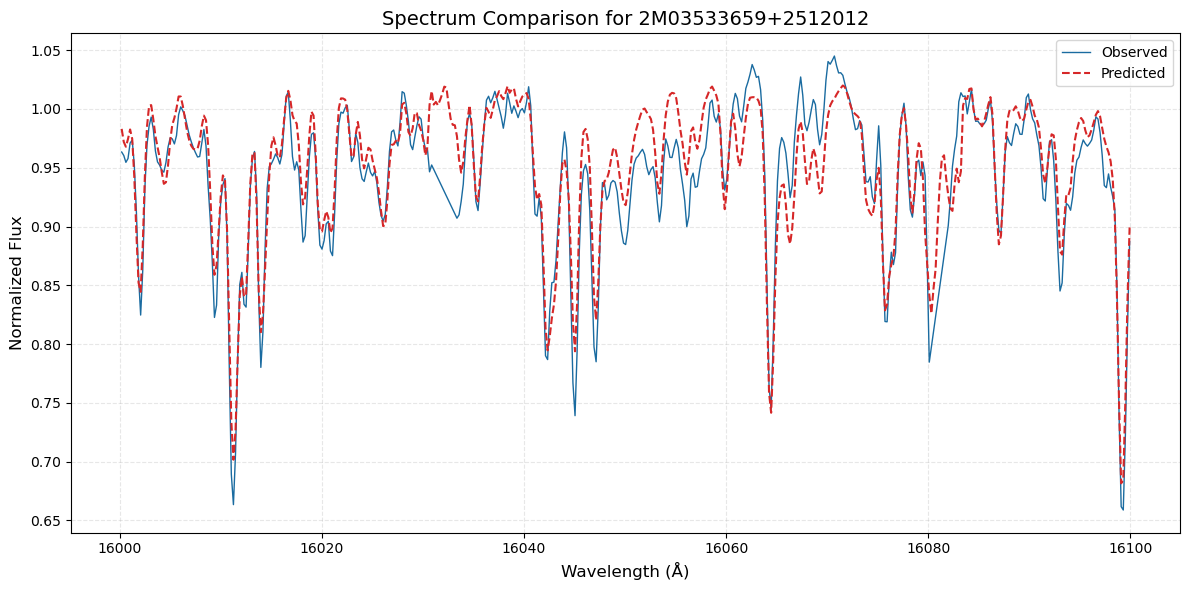

In [34]:
plt.figure(figsize=(12, 6))

# Create wavelength mask
wavelength_range_mask = (common_wavelength >= 16000) & (common_wavelength <= 16100)
wavelength_range = common_wavelength[wavelength_range_mask]
observed_flux_range = interpolated_flux_array[star_index][wavelength_range_mask]
predicted_flux_range = predicted_flux_star[wavelength_range_mask]

# Plot spectra
plt.plot(wavelength_range, observed_flux_range, 
         label='Observed', 
         color='#1a6ba0',  
         linewidth=1,
         alpha=1)

plt.plot(wavelength_range, predicted_flux_range, 
         label='Predicted', 
         color='#d62728',  
         linestyle='--',
         linewidth=1.5,
         alpha=1)

# Customize plot
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.title(f'Spectrum Comparison for {target_star_id}', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [35]:
def plot_gradient_spectra(common_wavelength, theta_lambda, s2_lambda, label_names, scaler, APOGEE_LINES):
    """
    Plot gradient spectra for each stellar label and intrinsic scatter.
    Gaps in the data (NaN values) will not be connected in the plot.

    Parameters:
    - common_wavelength (ndarray): Wavelength grid (Å)
    - theta_lambda (ndarray): Model coefficients (wavelength x features)
    - s2_lambda (ndarray): Intrinsic scatter values (wavelength)
    - label_names (list): Names of the labels ['Teff', 'logg', '[Fe/H]', '[Mg/Fe]', '[Si/Fe]']
    - scaler (StandardScaler): Fitted scaler object used during model training
    - APOGEE_LINES (dict): Dictionary containing lists of known absorption line wavelengths for elements
    """

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    # Colors for each label
    colors = {
        'Teff': '#2563eb',      # blue
        'logg': '#16a34a',      # green
        '[Fe/H]': '#9333ea',    # purple
        '[Mg/Fe]': '#dc2626',   # red
        '[Si/Fe]': '#ea580c'    # orange
    }

    # Ensure label_names is a list
    if isinstance(label_names, np.ndarray):
        label_names = label_names.tolist()

    # Initialize figure with separate subplots using constrained_layout
    fig = plt.figure(figsize=(15, 20), constrained_layout=True)
    gs = GridSpec(6, 1, height_ratios=[1, 1, 1, 1, 1, 1], hspace=0.4, figure=fig)

    # Get scaling factors
    scale_factors = 1.0 / scaler.scale_[:5]

    # Extract linear coefficients
    linear_theta = theta_lambda[:, 1:6]

    # Calculate all gradients first to determine independent scales
    gradients = []
    for i in range(len(label_names)):
        gradient = linear_theta[:, i] * scale_factors[i]
        gradients.append(gradient)

    # Plot each label's gradient spectrum
    for i, (label, gradient) in enumerate(zip(label_names, gradients)):
        ax = fig.add_subplot(gs[i])

        if np.all(np.isnan(gradient)):
            ax.text(0.5, 0.5, 'No Data Available', horizontalalignment='center',
                    verticalalignment='center', fontsize=12, color='gray')
            ax.set_ylim(-1, 1)  # Default limits
        else:
            # Find continuous segments (non-NaN regions)
            valid_mask = ~np.isnan(gradient)
            segments = []
            segment_start = None

            for j in range(len(valid_mask)):
                if valid_mask[j] and segment_start is None:
                    segment_start = j
                elif (not valid_mask[j] or j == len(valid_mask)-1) and segment_start is not None:
                    segment_end = j if not valid_mask[j] else j+1
                    segments.append((segment_start, segment_end))
                    segment_start = None

            # Plot each continuous segment separately
            for start, end in segments:
                ax.plot(common_wavelength[start:end], gradient[start:end],
                       color=colors.get(label, 'black'), 
                       linewidth=1.2,
                       label=f'∂f/∂{label}' if start == segments[0][0] else "")
            
            # Mark maximum sensitivity point
            if np.any(valid_mask):
                max_idx = np.nanargmax(np.abs(gradient))
                if not np.isnan(gradient[max_idx]):
                    ax.plot(common_wavelength[max_idx], gradient[max_idx],
                           'ro', markersize=5, label='Max Sensitivity')
                    ax.annotate(f'{common_wavelength[max_idx]:.1f} Å',
                              xy=(common_wavelength[max_idx], gradient[max_idx]),
                              xytext=(10, 10), textcoords='offset points',
                              arrowprops=dict(arrowstyle='->', color='red'),
                              fontsize=9)
            
            # Set y-limits based on this specific gradient's data
            valid_data = gradient[valid_mask]
            if len(valid_data) > 0:
                y_max = np.nanmax(np.abs(valid_data))
                y_min = -y_max
                if y_max == y_min:
                    # Apply a default padding if there's no variation
                    padding = y_max * 0.05 if y_max != 0 else 1e-3
                    ax.set_ylim(y_min - padding, y_max + padding)
                else:
                    padding = (y_max - y_min) * 0.05
                    ax.set_ylim(y_min - padding, y_max + padding)

            # Add APOGEE lines
            for element, lines in APOGEE_LINES.items():
                if (element != 'Fe' and label == f'[{element}/Fe]') or \
                   (element == 'Fe' and label == '[Fe/H]'):
                    line_colors = {'Fe': 'green', 'Mg': 'red', 'Si': 'blue'}
                    for line in lines:
                        ax.axvline(x=line, color=line_colors.get(element, 'gray'),
                                   alpha=0.3, linestyle='--', linewidth=1)

            # Customize plot
            ax.grid(True, alpha=0.3, linestyle=':')
            ax.set_ylabel(f'∂f/∂{label}', fontsize=12)
            ax.tick_params(axis='both', labelsize=10)

            # Add max gradient value
            if len(valid_data) > 0:
                abs_max_plot = np.nanmax(np.abs(valid_data))
                ax.text(0.02, 0.95, f'Max: {abs_max_plot:.2e}',
                        transform=ax.transAxes,
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
                        verticalalignment='top')

            # Handle x-axis labels
            if i < len(label_names) - 1:
                ax.set_xticks([])
            else:
                ax.set_xlabel('Wavelength (Å)', fontsize=12)
            
            # Add legend only once per subplot
            handles, labels_plot = ax.get_legend_handles_labels()
            if handles:
                ax.legend(loc='upper right', fontsize=10)

    # Plot intrinsic scatter with its own scale
    ax_scatter = fig.add_subplot(gs[5])

    if np.all(np.isnan(s2_lambda)):
        ax_scatter.text(0.5, 0.5, 'No Scatter Data Available', horizontalalignment='center',
                       verticalalignment='center', fontsize=12, color='gray')
        ax_scatter.set_ylim(-1, 1)  # Default limits
    else:
        # Find continuous segments for scatter plot
        valid_scatter = ~np.isnan(s2_lambda)
        scatter_segments = []
        segment_start = None

        for j in range(len(valid_scatter)):
            if valid_scatter[j] and segment_start is None:
                segment_start = j
            elif (not valid_scatter[j] or j == len(valid_scatter)-1) and segment_start is not None:
                segment_end = j if not valid_scatter[j] else j+1
                scatter_segments.append((segment_start, segment_end))
                segment_start = None

        # Plot each continuous segment of scatter separately
        for start, end in scatter_segments:
            scatter = np.sqrt(s2_lambda[start:end])
            ax_scatter.plot(common_wavelength[start:end], scatter,
                           color='#0891b2', linewidth=1.2,
                           label='Intrinsic Scatter σλ' if start == scatter_segments[0][0] else "")
        
        # Set y-limits based on scatter data
        valid_scatter_data = s2_lambda[valid_scatter]
        if len(valid_scatter_data) > 0:
            scatter = np.sqrt(valid_scatter_data)
            y_max = np.nanmax(scatter)
            y_min = np.nanmin(scatter)
            if y_max == y_min:
                # Apply a default padding if there's no variation
                padding = y_max * 0.05 if y_max != 0 else 1e-3
                ax_scatter.set_ylim(y_min - padding, y_max + padding)
            else:
                padding = (y_max - y_min) * 0.05
                ax_scatter.set_ylim(y_min - padding, y_max + padding)
        
        # Mark maximum scatter point
        if np.any(~np.isnan(s2_lambda)):
            max_scatter_idx = np.nanargmax(s2_lambda)
            if not np.isnan(s2_lambda[max_scatter_idx]):
                ax_scatter.plot(common_wavelength[max_scatter_idx], 
                              np.sqrt(s2_lambda[max_scatter_idx]),
                              'ro', markersize=5, label='Max Scatter')
                ax_scatter.annotate(f'{common_wavelength[max_scatter_idx]:.1f} Å',
                                  xy=(common_wavelength[max_scatter_idx], 
                                     np.sqrt(s2_lambda[max_scatter_idx])),
                                  xytext=(10, -15), textcoords='offset points',
                                  arrowprops=dict(arrowstyle='->', color='red'),
                                  fontsize=9)
        
        # Add APOGEE lines to scatter plot
        line_colors = {'Fe': 'green', 'Mg': 'red', 'Si': 'blue'}
        for element, lines in APOGEE_LINES.items():
            for line in lines:
                ax_scatter.axvline(x=line, color=line_colors.get(element, 'gray'),
                                 alpha=0.3, linestyle='--', linewidth=1)
        
        # Customize scatter plot
        ax_scatter.set_ylabel('σλ', fontsize=12)
        ax_scatter.set_xlabel('Wavelength (Å)', fontsize=12)
        ax_scatter.grid(True, alpha=0.3, linestyle=':')

        # Add legend for scatter plot
        legend_elements = [
            plt.Line2D([0], [0], color='#0891b2', label='Intrinsic Scatter σλ'),
            plt.Line2D([0], [0], color='red', linestyle='--', label='Mg lines'),
            plt.Line2D([0], [0], color='blue', linestyle='--', label='Si lines'),
            plt.Line2D([0], [0], color='green', linestyle='--', label='Fe lines')
        ]
        ax_scatter.legend(handles=legend_elements, loc='upper right', fontsize=10)

    # Add title
    plt.suptitle('Gradient Spectra and Intrinsic Scatter', fontsize=16, y=0.98)

    return fig


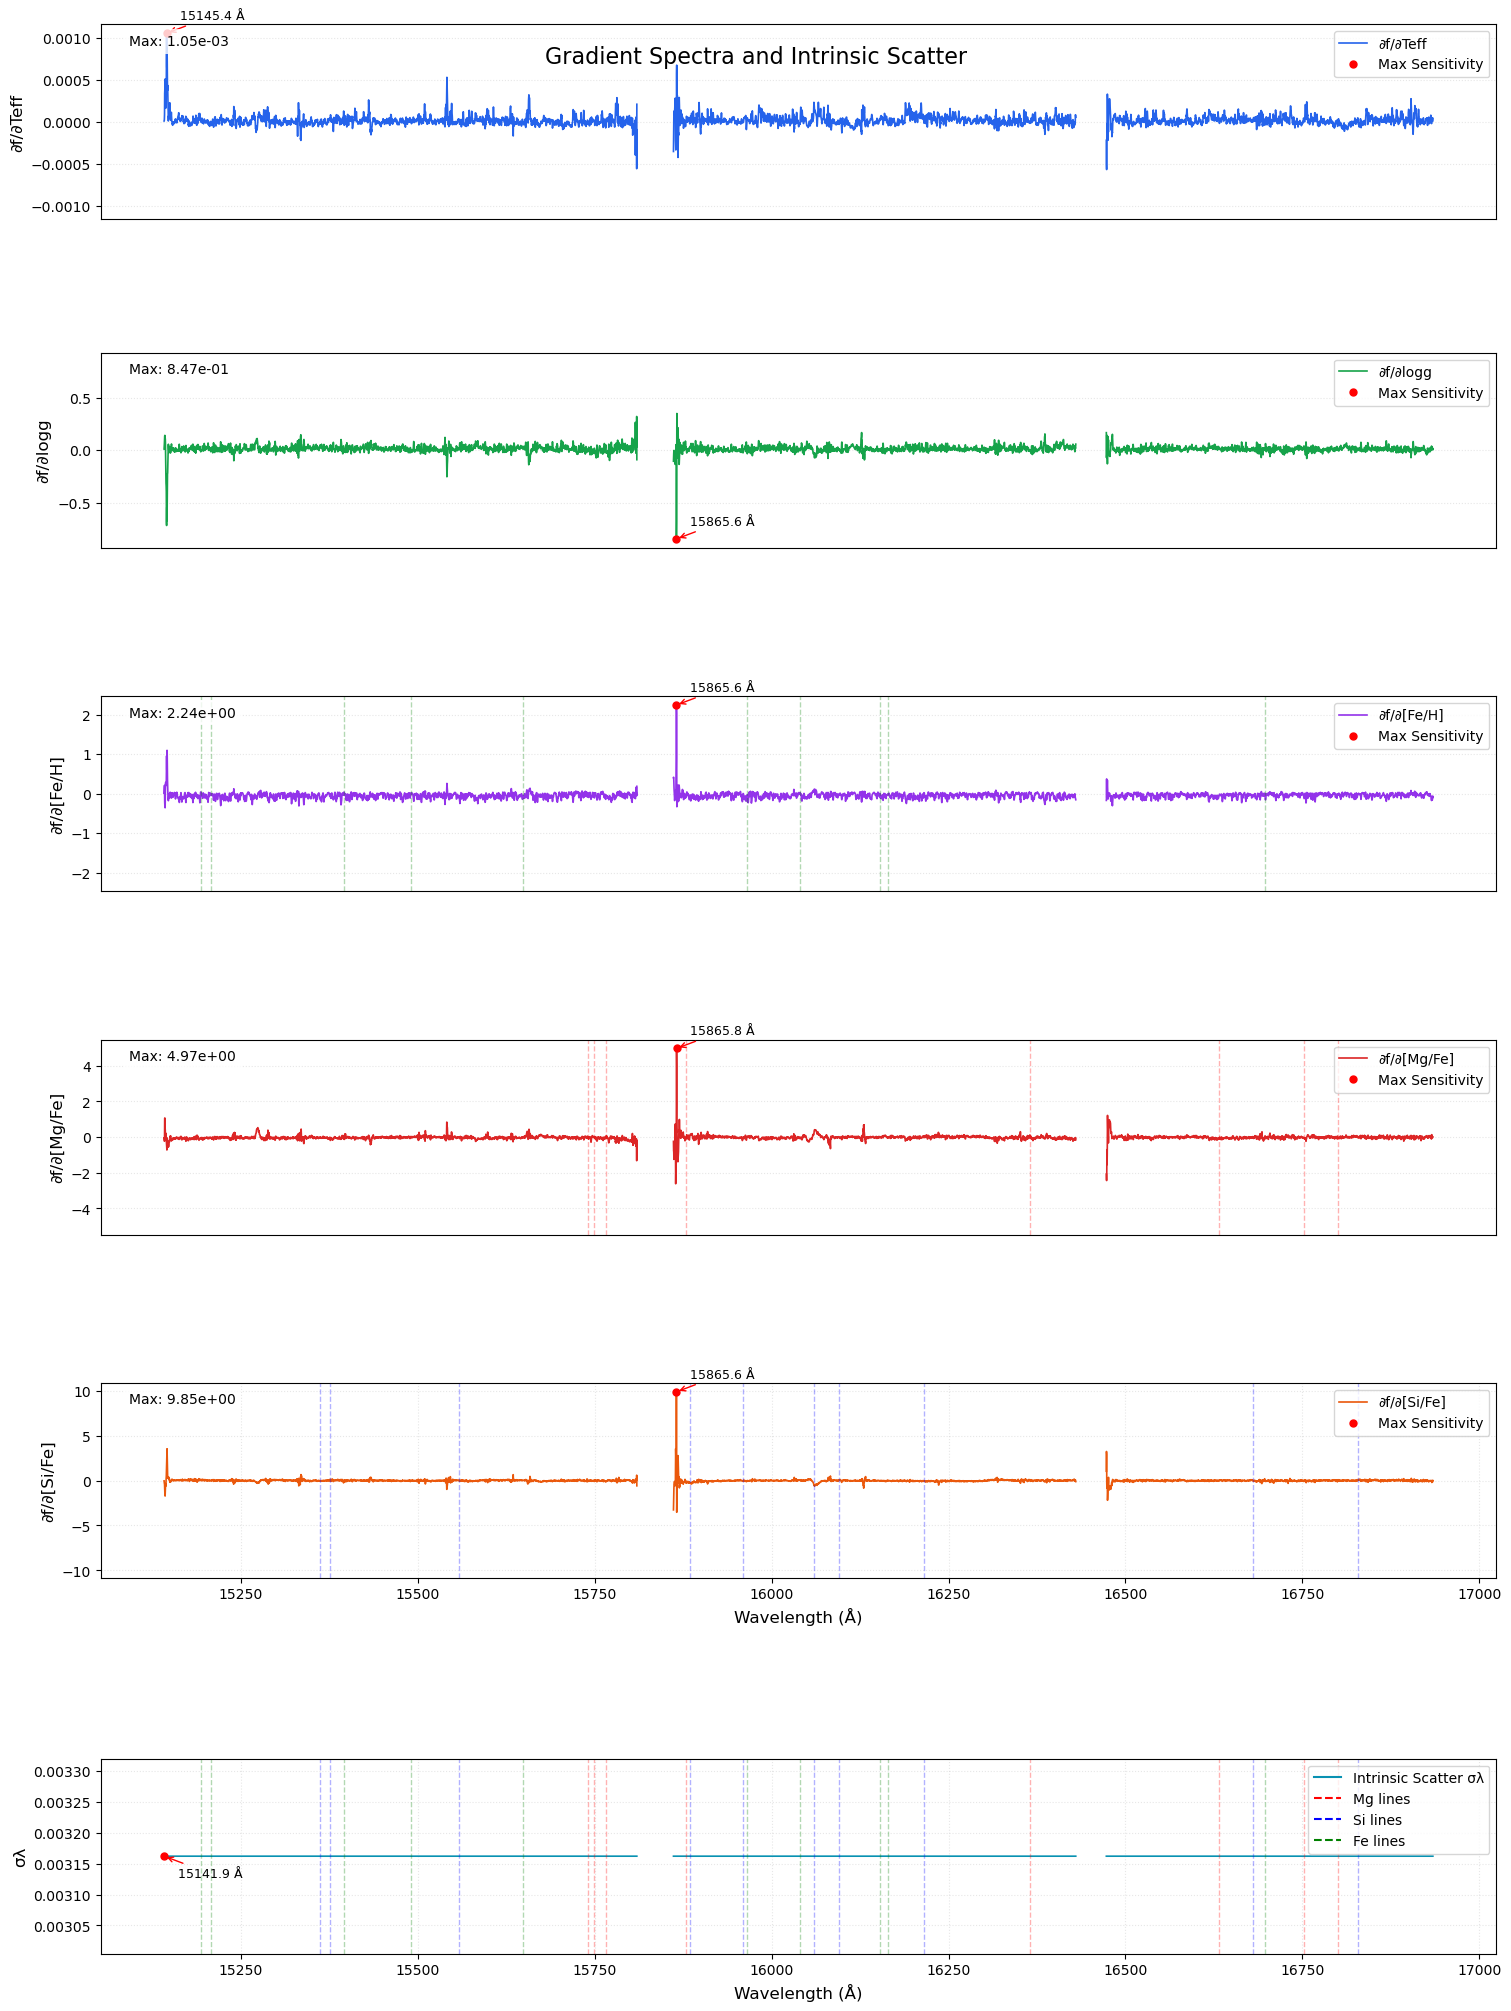

In [36]:
# Define your labels
label_names = ['Teff', 'logg', '[Fe/H]', '[Mg/Fe]', '[Si/Fe]']

# Define APOGEE_LINES
APOGEE_LINES = {
    'Fe': [15194.492, 15207.526, 15395.718, 15490.339,
           15648.510, 15964.867, 16040.657, 16153.247,
           16165.032, 16697.635],
    'Mg': [15740.7, 15748.9, 15765.8, 15879.5,
           16364.8, 16632.0, 16752.2, 16799.5],
    'Si': [15361.5, 15376.8, 15557.8, 15884.5,
           15960.1, 16060.0, 16094.8, 16215.7,
           16680.8, 16828.2]
}

# Plot gradient spectra and intrinsic scatter
fig = plot_gradient_spectra(common_wavelength, theta_lambda, s2_lambda, label_names, scaler, APOGEE_LINES)
plt.show()

In [37]:
# Process the cross-validation set
cv_normalized_flux, cv_errors, cv_wavelengths = process_spectra_list(
    cv_flux_files,            # List of CV set spectra file paths
    continuum_wavelengths,    # Continuum wavelengths used for normalization
    plot=False                # Set to True if you want to visualize each spectrum
)

# Now interpolate the CV spectra onto the common wavelength grid
cv_interpolated_flux_list = []
cv_interpolated_error_list = []

# Loop through CV spectra and interpolate
for i in tqdm(range(len(cv_normalized_flux)), desc="Interpolating CV Spectra"):
    wl = cv_wavelengths[i]
    flux = cv_normalized_flux[i]
    error = cv_errors[i]
    
    # Check if the length of wavelength matches flux arrays
    if len(wl) != len(flux):
        print(f"CV Spectrum {i}: Mismatched lengths - Wavelength: {len(wl)}, Flux: {len(flux)}, Error: {len(error)}")
        continue
    
    # Interpolate flux and error using your existing interpolate_spectrum function
    interp_flux, interp_error = interpolate_spectrum(wl, flux, error, common_wavelength)
    
    cv_interpolated_flux_list.append(interp_flux)
    cv_interpolated_error_list.append(interp_error)

# Convert the lists to NumPy arrays
cv_interpolated_flux_temp = np.array(cv_interpolated_flux_list)
cv_interpolated_error_temp = np.array(cv_interpolated_error_list)

##TEST##
cv_interpolated_flux_array = cv_interpolated_flux_temp
cv_interpolated_error_array = cv_interpolated_error_temp

print(f"Interpolated {len(cv_interpolated_flux_temp)} CV spectra successfully.")
print(f"CV interpolated flux array shape: {cv_interpolated_error_temp.shape}")

Interpolating CV Spectra: 100%|█████████████| 357/357 [00:00<00:00, 1871.67it/s]

Interpolated 357 CV spectra successfully.
CV interpolated flux array shape: (357, 8789)


In [38]:
cv_labels

array([[ 5.0229141e+03,  3.7434695e+00,  7.4253999e-02,  5.5338599e-02,
        -1.2065396e-02],
       [ 4.5964868e+03,  2.5575805e+00,  1.0866000e-01,  7.5209007e-02,
         2.4608597e-02],
       [ 4.7913291e+03,  2.5556281e+00, -3.4832999e-01,  1.1452201e-01,
         5.1953614e-02],
       ...,
       [ 4.7214609e+03,  2.3210721e+00, -2.3650999e-01,  2.4339299e-01,
         1.7712060e-01],
       [ 4.2595474e+03,  2.2071574e+00,  2.6585999e-01,  5.4774016e-02,
        -6.3798130e-03],
       [ 4.3439155e+03,  2.1247990e+00,  2.4304999e-01,  1.1477008e-02,
         4.2446598e-02]], dtype=float32)

In [39]:
def predict_normalized_spectrum_cv(labels, theta_lambda, scaler, poly):
    """
    Predict the normalized flux spectrum given the labels.
    
    Parameters:
    - labels: array-like, shape (n_labels,)
    - theta_lambda: ndarray, shape (n_pixels, n_features)
    - scaler: StandardScaler object used for scaling labels
    - poly: PolynomialFeatures object used for feature transformation
    
    Returns:
    - predicted_flux: ndarray, shape (n_pixels,)
    """
    # Scale the labels
    labels_scaled = scaler.transform(labels.reshape(1, -1))
    
    # Transform labels to polynomial features using the existing poly
    X = poly.transform(labels_scaled)
    
    # Predict the normalized flux
    predicted_flux = X @ theta_lambda.T
    
    return predicted_flux.flatten()

In [40]:
predicted_flux_cv = np.zeros((cv_labels.shape[0], theta_lambda.shape[0]))

print("Predicting fluxes for CV set stars...")
for i in tqdm(range(cv_labels.shape[0]), desc="Predicting CV Fluxes"):
    labels_star = cv_labels[i]  # Extract labels for the i-th CV star
    predicted_flux = predict_normalized_spectrum_cv(labels_star, theta_lambda, scaler, poly)
    predicted_flux_cv[i] = predicted_flux

print("Flux prediction for CV set completed.")
print(f"Predicted CV Flux Array Shape: {predicted_flux_cv.shape}")  # Should be (357, 8789)


Predicting fluxes for CV set stars...


Predicting CV Fluxes: 100%|█████████████████| 357/357 [00:00<00:00, 7271.95it/s]

Flux prediction for CV set completed.
Predicted CV Flux Array Shape: (357, 8789)


In [41]:
# Define the list of columns to exclude (multidimensional columns)
excluded_columns = [
    'FPARAM_GRID', 'CHI2_GRID', 'FPARAM', 'FPARAM_COV', 'PARAM', 'PARAM_COV',
    'PARAMFLAG', 'FELEM', 'FELEM_ERR', 'X_H', 'X_H_ERR', 'X_M', 'X_M_ERR',
    'ELEM_CHI2', 'ELEMFRAC', 'ELEMFLAG', 'X_H_SPEC', 'X_M_SPEC', 'VISIT_PK'
]

# Get all column names from data_filtered
all_columns = data_filtered.colnames

# Define the list of columns to keep (exclude the problematic ones)
columns_to_keep = [col for col in all_columns if col not in excluded_columns]

# Create a new Astropy Table with only the desired columns
data_filtered_df = data_filtered[columns_to_keep]

data_filtered_df

FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,ASPCAP_CHI2,ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,EXTRATARG,MEMBERFLAG,MEMBER,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG
bytes64,bytes30,bytes58,bytes71,bytes77,bytes6,int32,bytes20,bytes30,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,bytes16,float32,bytes32,float32,float32,int32,int32,int32,int32,int32,int32,bytes132,bytes32,bytes32,int32,float32,float32,int64,bytes132,int64,bytes132,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,int64,bytes256,float32,float32,float32,int32,int64,bytes10,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32,float32,int32
apStar-dr17-2M03501997+2458304.fits,2M03501997+2458304,apo25m.K2_C4_168-21.2M03501997+2458304,apogee.apo25m.stars.K2_C4_168-21.2M03501997+24

In [42]:
# Convert Astropy Table to Pandas DataFrame
data_filtered_df = data_filtered[columns_to_keep].to_pandas()
# Decode the byte strings in the DataFrame
for column in data_filtered_df.columns:
    if data_filtered_df[column].dtype == object:  # Only process object (string) columns
        first_value = data_filtered_df[column].dropna().iloc[0] if not data_filtered_df[column].empty else None
        if isinstance(first_value, bytes):
            data_filtered_df[column] = data_filtered_df[column].apply(
                lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
            )

# Filter DataFrame to only include stars in spectra_dict
data_filtered_df = data_filtered_df[data_filtered_df['APOGEE_ID'].isin(spectra_dict.keys())]

# Add the FITS file paths from the dictionary
data_filtered_df['FITS_File'] = data_filtered_df['APOGEE_ID'].map(spectra_dict)

missing_files = data_filtered_df[~data_filtered_df['FITS_File'].apply(os.path.exists)]

/var/folders/yb/gm3s7q8j7rjchq61y16sy76c0000gn/T/ipykernel_23661/345874683.py:67: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[idx, 1].set_xlim(x_min, x_max)


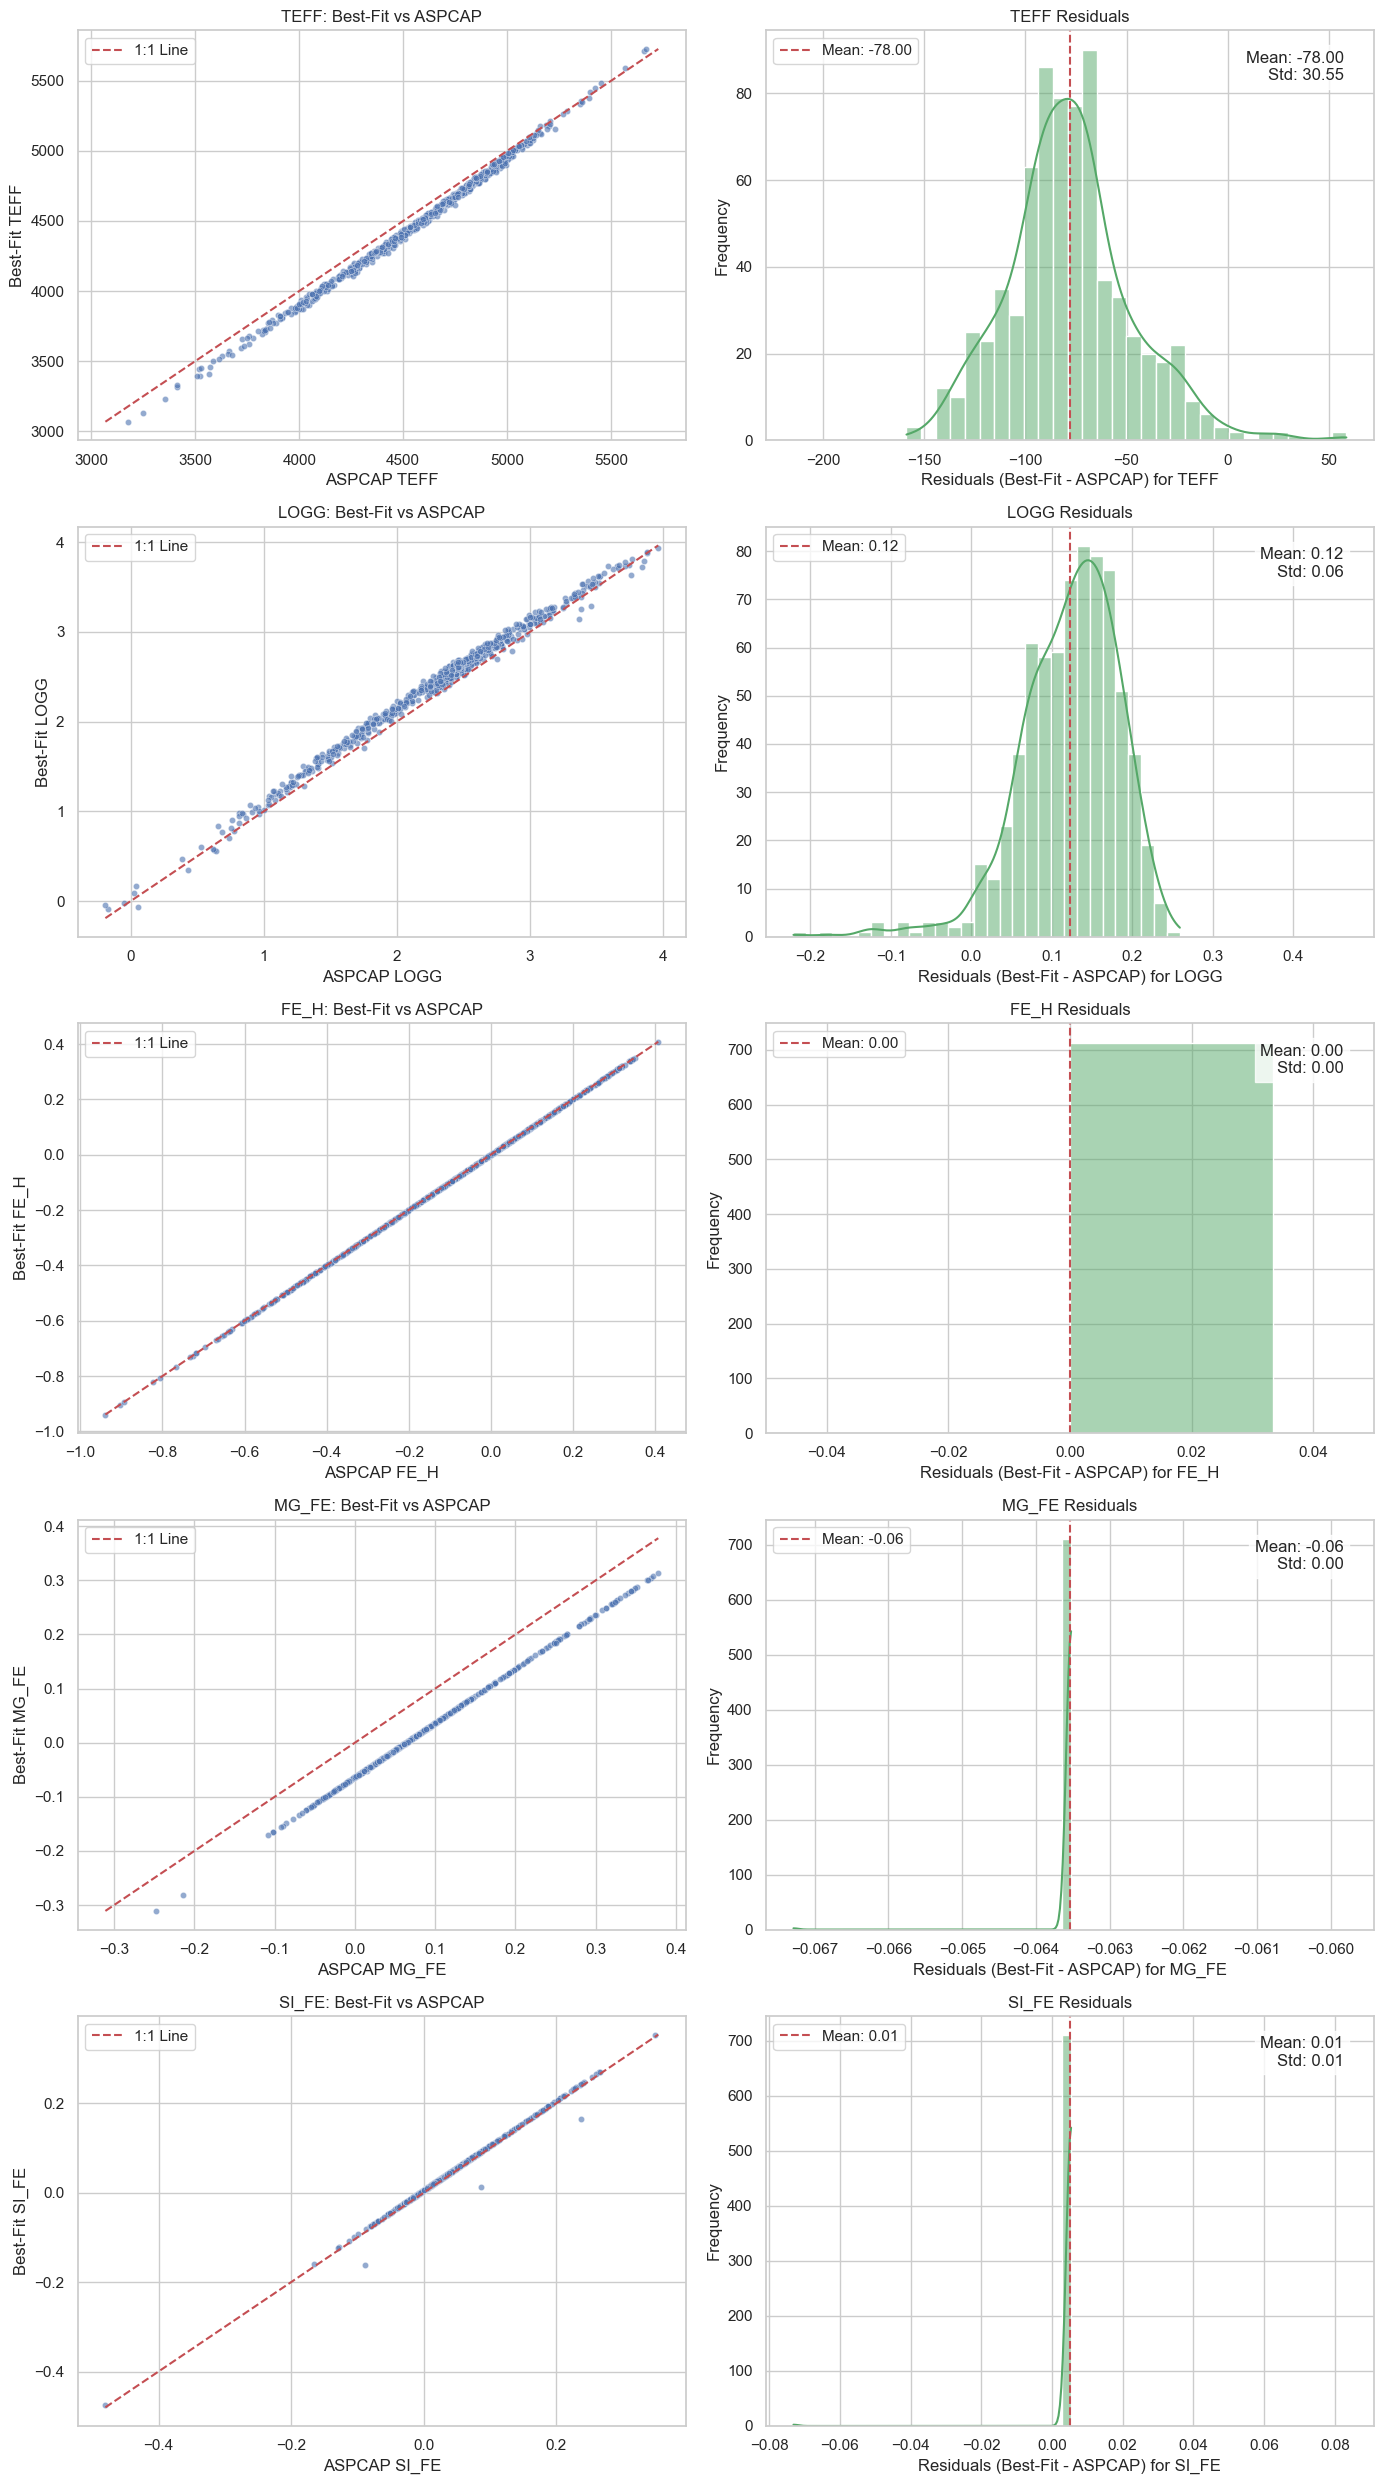

In [45]:
# Define the parameters and their corresponding columns
param_mapping = {
    'TEFF': ('TEFF', 'TEFF_SPEC'),
    'LOGG': ('LOGG', 'LOGG_SPEC'),
    'FE_H': ('FE_H', 'FE_H_SPEC'),
    'MG_FE': ('MG_FE', 'MG_FE_SPEC'),
    'SI_FE': ('SI_FE', 'SI_FE_SPEC')
}

# Create the subplot grid
sns.set(style="whitegrid")
fig, axs = plt.subplots(len(param_mapping), 2, figsize=(14, 5 * len(param_mapping)))

# Loop through parameters and create plots
for idx, (param, (aspcap_col, spec_col)) in enumerate(param_mapping.items()):
    
    if aspcap_col in data_filtered_df.columns and spec_col in data_filtered_df.columns:
        # Get the data
        x_data = data_filtered_df[aspcap_col].values
        y_data = data_filtered_df[spec_col].values
        
        # Remove any NaN values
        mask = ~(np.isnan(x_data) | np.isnan(y_data))
        x_data = x_data[mask]
        y_data = y_data[mask]
        
        # Scatter Plot
        sns.scatterplot(
            x=x_data,
            y=y_data,
            ax=axs[idx, 0],
            s=20,
            alpha=0.6,
            edgecolor='w'
        )
        
        # One-to-one line
        min_val = min(x_data.min(), y_data.min())
        max_val = max(x_data.max(), y_data.max())
        axs[idx, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
        
        # Labels and title
        axs[idx, 0].set_xlabel(f'ASPCAP {param}')
        axs[idx, 0].set_ylabel(f'Best-Fit {param}')
        axs[idx, 0].set_title(f'{param}: Best-Fit vs ASPCAP')
        axs[idx, 0].legend()
        
        # Residuals Histogram
        residuals = y_data - x_data
        mean_residual = np.mean(residuals)
        std_residual = np.std(residuals)
        
        # Set x-axis limits symmetrically around the mean
        max_abs_dev = max(abs(residuals - mean_residual))
        x_min = mean_residual - max_abs_dev - 0.1 * max_abs_dev  # Add 10% padding
        x_max = mean_residual + max_abs_dev + 0.1 * max_abs_dev
        
        sns.histplot(
            residuals,
            bins=30,
            kde=True,
            ax=axs[idx, 1],
            color='g'
        )
        
        # Center the plot around the mean
        axs[idx, 1].set_xlim(x_min, x_max)
        
        # Add vertical line at mean
        axs[idx, 1].axvline(mean_residual, color='r', linestyle='--', label=f'Mean: {mean_residual:.2f}')
        
        axs[idx, 1].set_xlabel(f'Residuals (Best-Fit - ASPCAP) for {param}')
        axs[idx, 1].set_ylabel('Frequency')
        axs[idx, 1].set_title(f'{param} Residuals')
        
        # Add statistics to residuals plot
        stats_text = f'Mean: {mean_residual:.2f}\nStd: {std_residual:.2f}'
        axs[idx, 1].text(0.95, 0.95, stats_text,
                        transform=axs[idx, 1].transAxes,
                        verticalalignment='top',
                        horizontalalignment='right',
                        bbox=dict(facecolor='white', alpha=0.8))
        axs[idx, 1].legend()
        
    else:
        # If columns don't exist, display error message on plots
        axs[idx, 0].text(0.5, 0.5, 'Missing Data',
                        ha='center', va='center',
                        transform=axs[idx, 0].transAxes)
        axs[idx, 1].text(0.5, 0.5, 'Missing Data',
                        ha='center', va='center',
                        transform=axs[idx, 1].transAxes)

plt.tight_layout()
plt.show()